# Latent Sentiment Analysis
In this notebook we provide an example of the **Latent Sentiment Analysis (LSA)** applied to the problem of finding similarities between different documents. In particular, we will consider the abstracts of the technical chapters of my PhD thesis.

In [1]:
#load all necessary libraries
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import os
from collections import Counter

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.o

In [2]:
#read all abstract files from the 'abstracts' folder
path = 'abstracts/'
docs = []
docs_name = []
for fileName in os.listdir(path):
    fileIn = open(path + fileName,'r')
    docs.append(fileIn.read())
    docs_name.append(fileName)
    fileIn.close()

In [3]:
print('The list of file names reads:')
print(docs_name)
print('\nAs an example, the first abstract reads:')
print(docs[0])

The list of file names reads:
['ab13.txt', 'lp.txt', 'quasi.txt', 'yukawa.txt', 'poly.txt', 'pca.txt']

As an example, the first abstract reads:
In this Chapter we investigate  binary nucleation  of the AB13 crystal from a binary fluid phase of nearly-hard spheres. We calculate the nucleation barrier and nucleation rate as a function of supersaturation and draw a comparison with nucleation of  single component and other binary crystals. To follow the nucleation process, we employ a neural network to identify the AB13 phase from the binary fluid phase and the competing fcc crystal with single-particle resolution and significant accuracy in the case of bulk phases. We show that AB13 crystal nucleation  proceeds via a co-assembly process where large spheres and icosahedral small-sphere clusters simultaneously attach to the nucleus. Our results lend strong support for a classical pathway that is well-described by classical nucleation theory,  even though the binary fluid phase is highly st

**NOTE:** 'ab13.txt' and 'lp.txt' should be detected as similar documents, as they are both about binary crystal nucleation. The same holds for 'quasi.txt' and 'yukawa.txt', which are both on inverse design methods, and for 'poly.txt' and 'pca.txt', which are both about the crystal polymorphs of hard-sphere systems.

In [4]:
#initialise porter for the stemming operation
porter = PorterStemmer()

In [5]:
#define the function used to pre-process the corpus
def pre_process(doc):
    '''
    Input:
        doc: a document in the format of a single string
    Output:
        stemmed: the pre-processed document -- a list of tokens
    '''
    nopunct = "".join([char for char in doc if char not in string.punctuation])
    lower = nopunct.lower()
    tokens = nltk.word_tokenize(lower)
    nostop = [word for word in tokens if word not in stopwords.words('english')]
    stemmed = [porter.stem(word) for word in nostop]
    
    return stemmed

In [6]:
#apply the pre-processing function to all documents
pre_processed_docs = [pre_process(doc) for doc in docs]

In [7]:
#print the first five pre-processed tokens of the first document -- ab13.txt
pre_processed_docs[0][:5]

['chapter', 'investig', 'binari', 'nucleat', 'ab13']

Note how the words are converted to **lower case** (from Chapter to chapter), and how they have been **stemmed** (investig, binari, nucleat). Also, **stopwords** like 'in', 'this', and 'we', have been removed.

In [8]:
#build vocab of unique words for each document, keeping only those which appear at least word_count_threshold times
vocab = []
for doc in pre_processed_docs:
    vocab.extend(doc)
vocab_counter = Counter(vocab)

word_count_threshold = 2
vocab_filtered = [word for word in vocab_counter.keys() if vocab_counter[word]>word_count_threshold]
print("Out of the " + str(len(set(vocab))) + " unique words of our corpus, keeping only the words that appear " + str(word_count_threshold) + " times, we are left with a vocabulary of " + str(len(vocab_filtered)) + " words.")

Out of the 236 unique words of our corpus, keeping only the words that appear 2 times, we are left with a vocabulary of 31 words.


In [9]:
#store the number of samples (documents) and the number of features (unique words considered)
n_docs = len(pre_processed_docs)
n_features = len(vocab_filtered)

In [10]:
#build a frequency vocabulary for each document, which will be needed in the tf-idf matrix calculation
manydoc_dict = {}
for word in vocab_filtered:
    manydoc_dict[word] = 0
    for this_vocab in pre_processed_docs:
        if word in this_vocab:
            manydoc_dict[word] += 1

In [11]:
print('The word "binari" appears in ' + str(manydoc_dict['binari']) + ' documents out of ' + str(n_docs))
print('The word "chapter" appears in ' + str(manydoc_dict['chapter']) + ' documents out of ' + str(n_docs))

The word "binari" appears in 2 documents out of 6
The word "chapter" appears in 6 documents out of 6


In [12]:
#function to build the term-frequency-inverse-document-frequency matrix from the pre-processed documents
def tf_idf(pre_processed_docs):
    '''
    Input:
        pre_processed_docs: a list of pre-processed documents, where each of them is a list of tokens
    Output:
        tf_idx_matrix: a (sparse) matrix of shape (n_docs,n_features) populated with tf-idf scores
    '''
    tf_idf_matrix = np.full((n_docs,n_features),0.0)
    for doc_id in range(n_docs):
        for word_id, word in enumerate(vocab_filtered):
            word_count = pre_processed_docs[doc_id].count(word)
            total_count = len(pre_processed_docs[doc_id])
            idf = np.log(n_docs/manydoc_dict[word])
            tf_idf_matrix[doc_id,word_id] = (float(word_count)/total_count)*idf
    return tf_idf_matrix
    
tf_idf_matrix = tf_idf(pre_processed_docs)

In [13]:
#scaling of the data so that it has zero-mean and unit variance
sc = StandardScaler()
scaled_tf_idf_matrix = sc.fit_transform(tf_idf_matrix)

In [14]:
#single value decomposition applied to the scaled tf-idf matrix
svd = TruncatedSVD(n_components=n_docs)
svd.fit(scaled_tf_idf_matrix)
svd_tf_idf_matrix = svd.transform(scaled_tf_idf_matrix)

Text(0.5, 1.0, 'Cumulative ratio of explained variance')

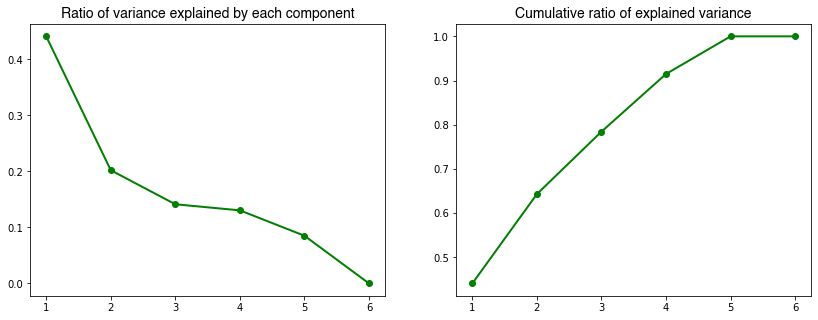

In [15]:
#in order to check the effective dimensionality of the system, we check the variance explained along each component
hfont = {'family':'sans-serif','fontname':'Helvetica', 'size':14}

x = np.arange(1,n_docs+1,1)
cumulative_ratio = np.array([np.sum(svd.explained_variance_ratio_[0:i+1]) for i in range(n_docs)])

fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].plot(x, svd.explained_variance_ratio_, marker='o', color='g', lw=2)
axs[0].set_title('Ratio of variance explained by each component', **hfont)
axs[1].plot(x, cumulative_ratio, marker='o', color='g', lw=2)
axs[1].set_title('Cumulative ratio of explained variance', **hfont)

In [16]:
#choose to only keep 3 components
components_to_consider = 3
print("The percentage of variance explained using " + str(components_to_consider) + " components is equal to "+ str(round(cumulative_ratio[components_to_consider-1]*100,1))+"%")

The percentage of variance explained using 3 components is equal to 78.4%


In [17]:
#find the 5 words that contribute the most to each of the first 3 components, note that we are not taking into account the case in which two different words contribute with the same exact amount to a component
def most_important_words(input_vec,vocab_filtered,n_words=5):
    '''
    Input:
        input_vec: the component of which we want to find the most relevant words
        vocab_filtered: the vocabulary used in this exercise
        n_words: the number of most relevant words to find
    Output:
        words_list: a list containing the most relevant words which contribute to the input vector
    '''
    abs_vec = list(np.abs(input_vec))
    ordered_vec = np.copy(abs_vec)
    ordered_vec.sort()
    values_to_find = ordered_vec[-n_words:]
    index_list = [abs_vec.index(value) for value in values_to_find]
    words_list = [vocab_filtered[index] for index in index_list]
    return words_list


for component in range(components_to_consider):
    print(component,most_important_words(svd.components_[component],vocab_filtered))

0 ['interact', 'paramet', 'sphere', 'algorithm', 'fluid']
1 ['lave', 'particl', 'colloid', 'polymorph', 'use']
2 ['particl', 'fivefold', 'nucleat', 'studi', 'ab13']


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


<AxesSubplot:>

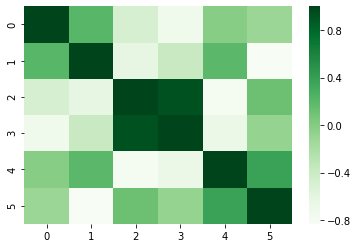

In [18]:
#compute the cosine similarity between the projections of the documents along the first three principal components and plot it as a heatmap
svd_cos_sim = cosine_similarity(svd_tf_idf_matrix[:,:components_to_consider])
seaborn.heatmap(svd_cos_sim, cmap='Greens')

In [19]:
#find the most similar abstract for each of the abstracts
for i in range(n_docs):
    vec = np.copy(svd_cos_sim[i])
    vec.sort()
    second_best = vec[-2]
    most_similar_doc = np.argwhere(svd_cos_sim[i] == second_best)[0][0]
    print("The most similar document to " + docs_name[i] + " is " + docs_name[most_similar_doc])

The most similar document to ab13.txt is lp.txt
The most similar document to lp.txt is ab13.txt
The most similar document to quasi.txt is yukawa.txt
The most similar document to yukawa.txt is quasi.txt
The most similar document to poly.txt is pca.txt
The most similar document to pca.txt is poly.txt
